In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pymc3 as pm

import scipy.stats as stats

### Section 4.3 - A gaussian model of height

In [2]:
# R code 4.7

d = pd.read_csv('./rethinking/data/Howell1.csv', sep=';')

In [3]:
# R code 4.8 

d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
d.shape

(544, 4)

In [5]:
# R code 4.9

d['height'].head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

In [6]:
# R code 4.10

d2 = d[d.age >= 18]

In [7]:
d2.shape

(352, 4)

To get a normal distribution, centred at $\mu$, with standard deviation $\sigma^2$, use: ```stats.norm.pdf(x, mu, sigma)```

In [8]:
# R code 4.11 

mu = 178
sigma2 = 20

x = np.linspace(100, 250, 1000)
fx = pd.Series(stats.norm.pdf(x, mu, sigma2), index=x)

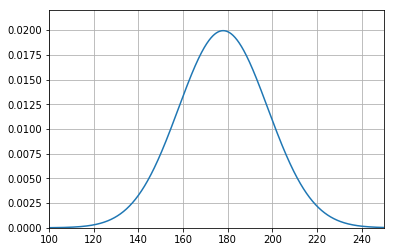

In [9]:
fx.plot()
plt.ylim([0, 0.022])
plt.grid();

In [10]:
# R code 4.12

x = np.linspace(-10, 60, 1000)
fx = pd.Series(stats.uniform.pdf(x, 0, 50), index=x)

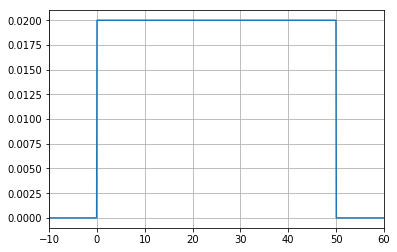

In [11]:
fx.plot(); plt.grid();

In [12]:
# R code 4.13

# Normal random variable
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
# The location (loc) keyword specifies the mean. The scale (scale) keyword specifies the standard deviation.

# Uniform random variable
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html
# This distribution is constant between loc and loc + scale.

num_samples = 10000

sample_mu = stats.norm.rvs(loc=178, scale=20, size=num_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=num_samples)

prior_h = pd.Series(stats.norm.rvs(loc=sample_mu, scale=sample_sigma, size=num_samples))

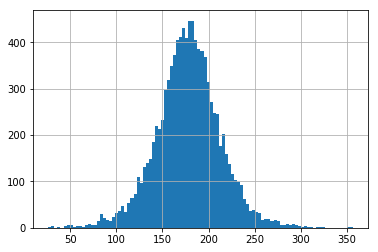

In [13]:
prior_h.hist(bins=100)

In [14]:
stats.norm.pdf([20, 30, 40, 50], 35, 100)

array([ 0.00394479,  0.00398444,  0.00398444,  0.00394479])

In [15]:
# R code 4.14

num_values = 200

mu_list = np.linspace(140, 160, num_values)
sigma_list = np.linspace(4, 9, num_values)

posterior = pd.DataFrame(np.dstack(np.meshgrid(mu_list, sigma_list)).reshape(-1, 2), 
                          columns=['mu', 'sigma'])

posterior['LL'] = 0
posterior['prod'] = 0
posterior['prob'] = 0

posterior.set_index(['mu', 'sigma'], inplace=True)

for (mu, sigma), _ in posterior.iterrows():
        
    # because the likelihood is on log scale, it can be summed
    # over all data points 
    log_likelihood = sum(stats.norm.logpdf(d2.height, mu, sigma))

    #
    mu_log_prior = stats.norm.logpdf(mu, 178, 20)
    sigma_log_prior = stats.uniform.logpdf(sigma, 0, 50)

    # priors and likelihood are on log scale, so sum instead of multiply
    posterior.loc[(mu, sigma), 'LL'] = log_likelihood
    posterior.loc[(mu, sigma), 'prod'] =  log_likelihood + mu_log_prior + sigma_log_prior            
    
posterior['prob'] = (posterior['prod'] - posterior['prod'].max()).apply(np.exp)

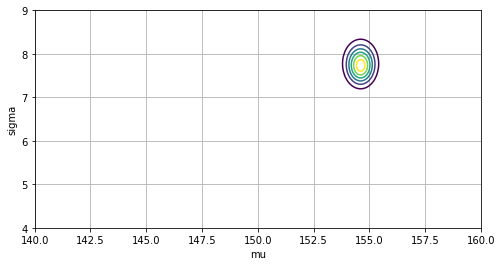

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))

ax.contour(mu_list, sigma_list, posterior.prob.unstack(level=0).values)
ax.grid(); ax.set_xlabel('mu'); ax.set_ylabel('sigma');

Making sure the output from R is same with this output

In [17]:
# post = pd.read_csv('./post.csv', index_col=0).set_index(['mu', 'sigma'])
# prob = pd.read_csv('./prob.csv', index_col=0).squeeze()

# r_prob = pd.DataFrame(index=range(200), columns=range(200))

# for i in range(200):
#     prob_index = i * 200
#     for j in range(200):
#         r_prob.iloc[i, j] = prob.iloc[prob_index + j]
        
# r_prob.set_index(mu_list, inplace=True)
# r_prob.columns = sigma_list

# r_prob.index.name = 'mu'
# r_prob.columns.name = 'sigma'

In [18]:
# plt.contour(mu_list, sigma_list, r_prob)
# plt.xlabel('mu'); plt.ylabel('sigma');

Problem here was that when I unstacked the dataframe, I had mu on the rows, and sigma on the columns, which produced a rotated contour plot. When plotting contour, make sure the columns/rows of the dataframe correspond to what you want to have on the x-axis, and y-axis, respectively.

##### Sampling from the posterior

In [19]:
# R code 4.17

num_samples = 10000

# make sure posterior probabilities sum to 1
row_probs = posterior.prob.div(posterior.prob.sum())
sample_rows = np.random.choice(np.arange(len(posterior)), num_samples, 
                               p=row_probs, replace=True)

sample_mu = posterior.index.get_level_values(0)[sample_rows]
sample_sigma = posterior.index.get_level_values(1)[sample_rows]

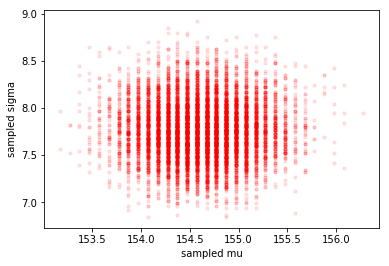

In [20]:
# R code 4.18

plt.scatter(sample_mu, sample_sigma, alpha=0.1, s=10, c='r')
plt.xlabel('sampled mu'); plt.ylabel('sampled sigma');

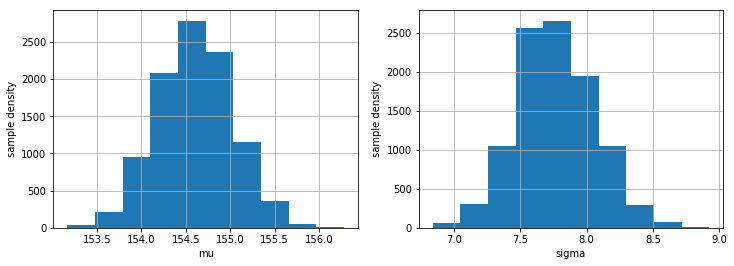

In [21]:
# R code 4.19

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 4))

pd.Series(sample_mu).hist(ax=ax_left)
pd.Series(sample_sigma).hist(ax=ax_right)

ax_left.set_xlabel('mu'); ax_left.set_ylabel('sample density')
ax_right.set_xlabel('sigma'); ax_right.set_ylabel('sample density')

In [22]:
# R code 4.20
pm.hpd(sample_mu, alpha=.89)

array([ 154.27135678,  154.3718593 ])

In [23]:
# R code 4.20
pm.hpd(sample_sigma, alpha=.89)

array([ 7.54271357,  7.61809045])

In [24]:
# R code 4.21

d3 = d2.height.head(20)

num_values = 200

mu_list = np.linspace(140, 160, num_values)
sigma_list = np.linspace(4, 9, num_values)

posterior = pd.DataFrame(np.dstack(np.meshgrid(mu_list, sigma_list)).reshape(-1, 2), 
                          columns=['mu', 'sigma'])

posterior['LL'] = 0
posterior['prod'] = 0
posterior['prob'] = 0

posterior.set_index(['mu', 'sigma'], inplace=True)

for (mu, sigma), _ in posterior.iterrows():
        
    # because the likelihood is on log scale, it can be summed
    # over all data points 
    log_likelihood = sum(stats.norm.logpdf(d3, mu, sigma))

    #
    mu_log_prior = stats.norm.logpdf(mu, 178, 20)
    sigma_log_prior = stats.uniform.logpdf(sigma, 0, 50)

    # priors and likelihood are on log scale, so sum instead of multiply
    posterior.loc[(mu, sigma), 'LL'] = log_likelihood
    posterior.loc[(mu, sigma), 'prod'] =  log_likelihood + mu_log_prior + sigma_log_prior            
    
posterior['prob'] = (posterior['prod'] - posterior['prod'].max()).apply(np.exp)

#
# Sampling
#

num_samples = 10000

# make sure posterior probabilities sum to 1
row_probs = posterior.prob.div(posterior.prob.sum())
sample_rows = np.random.choice(np.arange(len(posterior)), num_samples, 
                               p=row_probs, replace=True)

sample_mu = posterior.index.get_level_values(0)[sample_rows]
sample_sigma = posterior.index.get_level_values(1)[sample_rows]

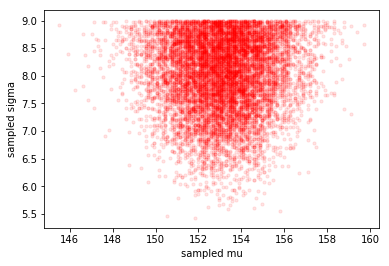

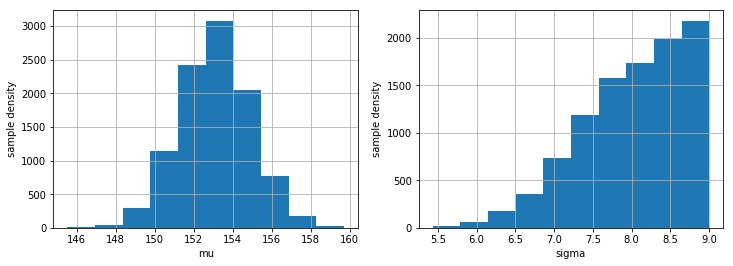

In [25]:
plt.scatter(sample_mu, sample_sigma, alpha=0.1, s=10, c='r')
plt.xlabel('sampled mu'); plt.ylabel('sampled sigma'); plt.show();

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 4))

pd.Series(sample_mu).hist(ax=ax_left)
pd.Series(sample_sigma).hist(ax=ax_right)

ax_left.set_xlabel('mu'); ax_left.set_ylabel('sample density')
ax_right.set_xlabel('sigma'); ax_right.set_ylabel('sample density')
plt.show();

##### 4.3.5 Fitting the model with map

Now we leave grid approximation behind and move to one of the great engines of applied statistics, the quadratic approximation. Our interest in the quadratic approximation is handy way to quickly make inferences about the shape of the posterior. The posterior's peak will lie at the _maximum a posteriori_ estimate (MAP), and we can get a useful image of the posterior's shape by using the quadratic approximation of the posterior distribution at this peak.

In [26]:
d = pd.read_csv('./rethinking/data/Howell1.csv', sep=';')
d2 = d[d.age >= 18]

In [27]:
#
# Using PyMC3 instead of the rethinking package to specify the model
#

from pymc3 import Model, Normal, Uniform

height_model = Model()
with height_model:
    
    mu = Normal('mu', mu=178, sd=20)
    sigma = Uniform('sigma', lower=0, upper=50)

    # Observed heights
    height = Normal('height', mu=mu, sd=sigma, observed=d2.height)
    
    # MAP
    map_estimate = pm.find_MAP(model=height_model)
    
    # Traces
    trace = pm.sample(2000, start=map_estimate)

100%|██████████| 2000/2000 [00:02<00:00, 779.33it/s]


In [28]:
pm.summary(trace, alpha=0.11)


mu:

  Mean             SD               MC Error         89% HPD interval
  -------------------------------------------------------------------
  
  154.592          0.418            0.013            [154.009, 155.277]

  Posterior quantiles:
  5.5            25             50             75             94.5
  |--------------|==============|==============|--------------|
  
  153.965        154.303        154.594        154.871        155.252


sigma:

  Mean             SD               MC Error         89% HPD interval
  -------------------------------------------------------------------
  
  7.765            0.307            0.011            [7.276, 8.248]

  Posterior quantiles:
  5.5            25             50             75             94.5
  |--------------|==============|==============|--------------|
  
  7.283          7.557          7.759          7.964          8.259



In [29]:
# Taken from:
# https://github.com/pymc-devs/pymc3/blob/967f41f853946ae569178faf4b3e8c814382f70e/pymc3/distributions/transforms.py
# - helper class to perform interval transform

class Interval():
    """Transform from real line interval [a,b] to whole real line."""

    name = "interval"

    def __init__(self, a,b):
        self.a = a
        self.b = b

    def backward(self, x):
        a, b = self.a, self.b
        r = (b - a) * np.exp(x) / (1 + np.exp(x)) + a
        return r

    def forward(self, x):
        a, b = self.a, self.b
        r = np.log((x - a) / (b - x))
        return r

In [30]:
interval = Interval(0, 50)
print(map_estimate['mu'], interval.backward(map_estimate['sigma_interval_']))

154.60704664788824 7.7403193394


Unfortunately, right about here I'm having problems with finding python equivalents for the functions in ```rethinking```. In particular, I can't find a normal (quadratic) approximation implementation, nor a variance-covariance implementation -- they must exist somewhere, I just gave up looking.

There are several ways to continue from here:
- find python equivalents (takes long to find and adapt, as equivalents are probably not 1-to-1)
- implement python equivalent to rethinking library (useful in understanding the concepts, takes long time)
- use R to run the examples I can't find an equivalent for in python 

Section 4.3 makes use of the quadratic approximation, and for this section, the examples in R are reproduced in a notebook in this folder (the name of the notebook should be self-explanatory). These R examples show how to fit the quadratic approximation using the ```rethinking``` package. More importantly, they describe how to sample from a multi-dimensional normal approximate distribution. Unfortunately, the code is encapsulated by a function in the ```rethinking``` package and (to me) it's not exactly clear what's going on. The author provides this explanation:

> (...) instead of sampling single values from a simple Gaussian distribution, we sample vectors of values from a multi-dimensional Gaussian distribution. (...)

The questions I'm asking here are: how exactly does this happen? what sort of values are contained by the vector? do we 'fix' the value of one parameter, sample from the distribution of the other, and then weight by the probability of the parameter we fixed in its marginal distribution?

I think studying the R code might be a solution to this. 

Not sure what's coming up next, but I think that as long as we're just fitting the models with grid-approximation or quadratic approximation just to draw samples from them, then I might as well just use pymc and draw samples from the posterior directly -- as this is the solution used later in the book anyway. I prefer this solution because it python-centric and also because using the rethinking package in R doesn't really provide any conceptual understanding of the fitting process anyway (it's just as black-boxy as sampling directly). 

### 4.4 Adding a predictor

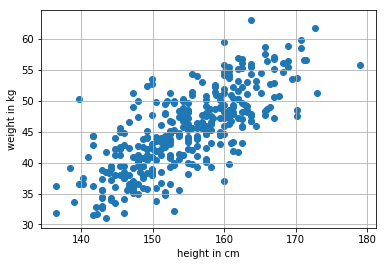

In [31]:
plt.scatter(d2.height, d2.weight)
plt.xlabel('height in cm'); plt.ylabel('weight in kg');
plt.grid();

Recall the basic Gaussian model: $$h_i \sim Normal(\mu, \sigma)$$ $$\mu \sim Normal(178, 20)$$ $$\sigma \sim Uniform(0, 50)$$

Into single predictor linear model: $$(1) ~ height_i \sim Normal(\mu, \sigma)$$ $$(2) ~ \mu_i = \alpha + \beta * weight_i$$ $$(3) ~ \alpha \sim Normal(178, 100)$$ $$(4) ~ \beta \sim Normal(0,10)$$ $$(5) ~ \sigma \sim Uniform(0, 50)$$



1. Likelihood
2. Linear model (\alpha, \beta are now parameters that must be described in the posterior)
3. Prior on $\alpha$
4. Prior on $\beta$
5. Prior on $\sigma$

---

- $\alpha: $ What is the expected height, when weight is 0? The parameter alpha answers this questions -- for this reason it is called the intercept.
- $\beta: $ What is the change in expected height, when weight changes by 1 unit? The parameter beta answers this question.

Jointly, there two parameters, together with weight, ask the golem to find a line that relates x to h, a line that passes through alpha when x is zero and has slope beta. That is a task that golems are very good at. **It's up to you, though, to be sure it's a good question.**

In [32]:
linear_height_model = pm.Model()

with linear_height_model:
        
    alpha = pm.Normal('alpha', mu=156, sd=100) # 158 is the mean of height
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    # Observed heights
    height = Normal('height', mu=alpha + beta * d2.weight, sd=sigma, observed=d2.height)

    # MAP
    map_estimate = pm.find_MAP(model=height_model)
    
    # Traces
    trace = pm.sample(5000, start=map_estimate, tune=1000) 

100%|██████████| 5000/5000 [00:09<00:00, 516.38it/s]


In [33]:
# pm.summary(trace)

**Centering** - the procedure of subtracting the mean of a variable from each value.

Notice below how beta and sigma are unchanged, but alpha is now centered on the mean of the data we observed. Which is equivalent to saying: alpha is the expected value of the outcome, when the predictor is **at its mean value**. This makes interpreting the intercept a lot easier

In [34]:
linear_height_model = pm.Model()

with linear_height_model:
        
    alpha = pm.Normal('alpha', mu=156, sd=100) # 158 is the mean of height
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    observed_heights = d2.height
    observed_weights = d2.weight
    
    # Observed heights
    height = Normal('height', mu=alpha + beta * (observed_weights - observed_weights.mean()), 
                    sd=sigma, observed=observed_heights)

    # MAP
    map_estimate = pm.find_MAP(model=linear_height_model)
    
    # Traces
    trace = pm.sample(10000, start=map_estimate) 

100%|██████████| 10000/10000 [00:06<00:00, 1434.43it/s]


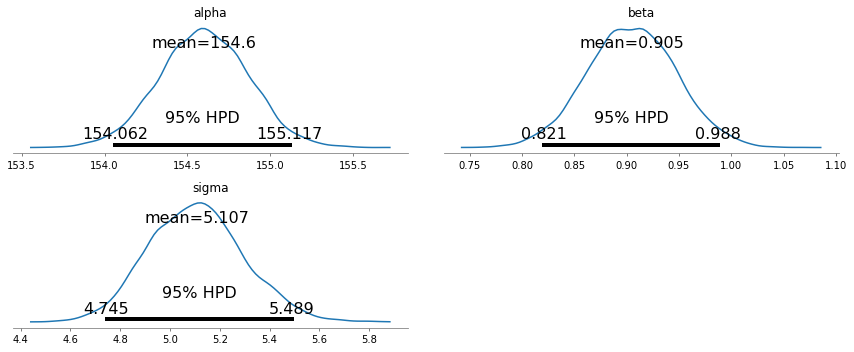

In [35]:
pm.plot_posterior(trace, kde_plot=True);

In [36]:
trace_df = pd.DataFrame(np.transpose([trace['alpha'], trace['beta'], trace['sigma']]), 
             columns=['alpha', 'beta_centered', 'sigma']).drop_duplicates()

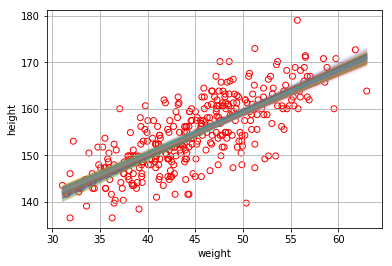

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

weights = d2.weight - d2.weight.mean()

ax.scatter(d2.weight, d2.height, facecolors='none', edgecolors='r')
ax.plot(d2.weight, map_estimate['alpha'] + weights * map_estimate['beta'])

rows = trace_df.iloc[np.random.choice(len(trace_df), 100, replace=True), :]

for index, row in rows.iterrows():
    ax.plot(d2.weight, row['alpha'] + weights * row['beta_centered'], alpha=0.2)
    

plt.xlabel('weight'); plt.ylabel('height');
plt.grid();

In [38]:
# R code 4.50
mu_at_50 = trace_df.alpha + trace_df.beta_centered * (50 - d2.weight.mean())

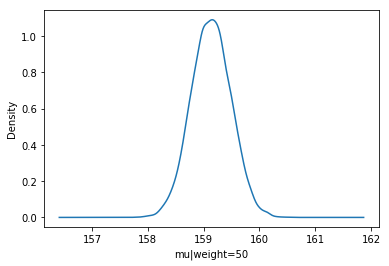

In [39]:
# R code 4.51 
mu_at_50.plot(kind='kde'); plt.xlabel('mu|weight=50')

In [40]:
pm.hpd(mu_at_50)

array([ 158.48212266,  159.86467068])

In [41]:
# R code 4.56-57

weights = pd.Series(np.linspace(30, 60, 30)) - d2.weight.mean()

accum = []
for index, sample in trace_df[['alpha', 'beta_centered']].iterrows():
     accum.append(sample['alpha'] + weights * sample['beta_centered'])
        
mus_for_weights = pd.DataFrame(accum)
mus_for_weights.columns = np.linspace(30, 60, 30)

accum = []
for weight, samples in mus_for_weights.T.iterrows():
    accum.append(pm.hpd(samples))
    
hpds_for_weights = pd.DataFrame(accum, index=np.linspace(30, 60, 30), columns=['HPD_lower', 'HPD_upper'])

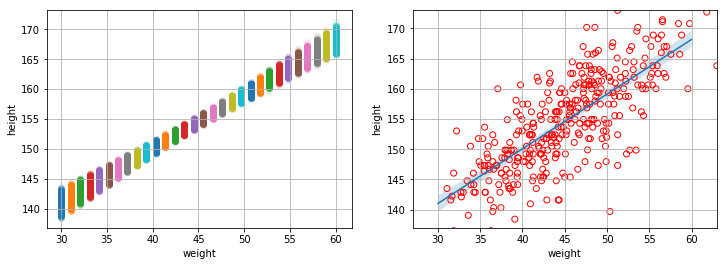

In [42]:
# R code 4.56-57

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 4))

for weight, samples in mus_for_weights.T.iterrows():
    ax_left.scatter([weight] * len(samples), samples, alpha=0.1)

ax_left.set_xlabel('weight'); ax_left.set_ylabel('height');
ax_left.grid();

#

# draw the mean line
mus_for_weights.mean().plot(ax=ax_right)

# draw the hpd interval
ax_right.fill_between(hpds_for_weights.index, y1=hpds_for_weights.HPD_lower, y2=hpds_for_weights.HPD_upper, alpha=0.2)

# draw the original data
ax_right.scatter(d2.weight, d2.height, facecolors='none', edgecolors='r')

# style the plot a bit
ax_right.set_xlabel('weight'); ax_right.set_ylabel('height');
ax_right.set_xlim([27, 63]); ax_right.set_ylim([137, 173]);
ax_right.grid();

In [43]:
pm.hpd(stats.norm.rvs(loc=178, scale=20, size=1000), alpha=.69)

array([ 169.80535346,  185.87413315])

In [44]:
import collections

In [45]:
accum_dict = collections.defaultdict(list)

weights = pd.Series(np.linspace(30, 60, 30)) - d2.weight.mean()

for weight in weights:
    for index, sample_row in trace_df.iterrows():
        mu = sample_row['alpha'] + weight * sample_row['beta_centered']
        sigma = sample_row['sigma']
        
        # random sample of heights
        rvs = stats.norm.rvs(loc=mu, scale=sigma, size=2)
        
        # collect them so we can compute HPD
        accum_dict[weight + d2.weight.mean()].extend(rvs)

In [46]:
prediction_samples = pd.DataFrame(accum_dict)

prediction_hpds = []
for weight, samples in prediction_samples.T.iterrows():
    hpd = pm.hpd(samples.values, alpha=.11)
    prediction_hpds.append(hpd)

prediction_hpds_df = pd.DataFrame(prediction_hpds, 
                                  index = weights + d2.weight.mean(), columns=['HPD_lower', 'HPD_upper'])

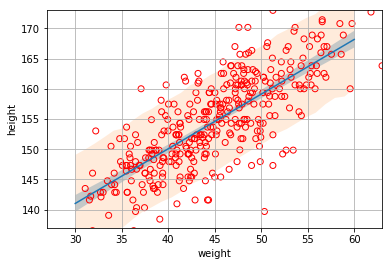

In [47]:
fig,ax_right = plt.subplots(1, 1, figsize=(6, 4))

# draw the mean line
mus_for_weights.mean().plot(ax=ax_right)

# draw the hpd interval for the mean line
ax_right.fill_between(hpds_for_weights.index, y1=hpds_for_weights.HPD_lower, 
                      y2=hpds_for_weights.HPD_upper, alpha=0.3)

# draw the hpd interval for predictions
ax_right.fill_between(prediction_hpds_df.index, y1=prediction_hpds_df.HPD_lower, 
                      y2=prediction_hpds_df.HPD_upper, alpha=0.15)

# draw the original data
ax_right.scatter(d2.weight, d2.height, facecolors='none', edgecolors='r')

# style the plot a bit
ax_right.set_xlabel('weight'); ax_right.set_ylabel('height');
ax_right.set_xlim([27, 63]); ax_right.set_ylim([137, 173]);
ax_right.grid();

### 4.5 Polynomial regression

In [48]:
d = pd.read_csv('./rethinking/data/Howell1.csv', sep=';')

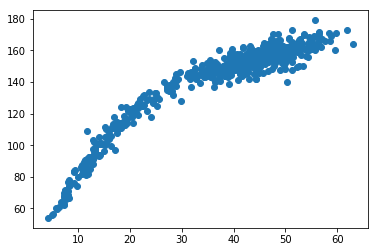

In [49]:
plt.scatter(d.weight, d.height)